In [1]:
from typing import Any
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split

import pytorch_lightning as pl

from torchmetrics import Accuracy, F1Score
from torchmetrics.aggregation import MeanMetric

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

## I. Model

### Create Loss function

In [2]:
class mad_loss(nn.Module):
    def __init__(self):
        super(mad_loss, self).__init__()

    def forward(self, predicted, target):
        return torch.mean(torch.abs(predicted - target))

class cfe_loss(nn.Module):
    def __init__(self):
        super(cfe_loss, self).__init__()

    def forward(self, predicted, target):
        # Calculate the cumulative sum of absolute errors (CFE)
        cfe_loss = torch.cumsum(torch.abs(predicted - target), dim=0)

        # The final loss is the last element of the cumulative sum
        loss = cfe_loss[-1]

        return loss

class ts_loss(nn.Module):
    def __init__(self):
        super(ts_loss, self).__init__()

    def forward(self, predicted, target):
        # Calculate the forecast errors
        forecast_errors = predicted - target

        # Calculate the cumulative sum of forecast errors
        cfe_loss = torch.cumsum(torch.abs(forecast_errors), dim=0)[-1]

        # Calculate the mean absolute deviation of forecast errors
        mean_absolute_deviation = torch.mean(torch.abs(forecast_errors))

        # Calculate the Tracking Signal
        ts_loss = cfe_loss / mean_absolute_deviation
        ts_loss = torch.mean(ts_loss)

        return ts_loss
    
class mape_loss(nn.Module):
    def __init__(self):
        super(mape_loss, self).__init__()

    def forward(self, predicted, target):
        # Ensure non-zero denominators to avoid division by zero
        target_nonzero = torch.where(target != 0, target, torch.tensor(1.0))
        
        # Calculate the absolute percentage errors
        absolute_percentage_errors = torch.abs((target - predicted) / target_nonzero)

        # Calculate the mean absolute percent error
        mape_loss = torch.mean(absolute_percentage_errors) * 100

        return mape_loss

mad_loss = mad_loss()
cfe_loss = cfe_loss()
ts_loss = ts_loss()
mape_loss = mape_loss()

    
dict_loss_fn = {"mad_loss": mad_loss, "cfe_loss": cfe_loss, \
                "ts_loss": ts_loss, "mape_loss": mape_loss, \
                "mse_loss": F.mse_loss}

### Create Model class

In [3]:
class LSTM1(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=104, batch_first=True)
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=104, out_features=52),
            nn.Linear(in_features=52, out_features=26),
            nn.Linear(in_features=26, out_features=1)
        )
        self.Tanh = nn.Tanh()

        
    def forward(self, x):
        x, (_, _) = self.lstm(x)
        x = self.Tanh(x)
        x = self.fc_layers(x)
        return x
    

class LSTM2(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=104, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=104, hidden_size=52, batch_first=True)
        self.fc_layers = nn.Linear(in_features=52, out_features=1)
        self.Tanh = nn.Tanh()

        
    def forward(self, x):
        x, (_, _) = self.lstm1(x)
        x = self.Tanh(x)
        x, (_, _) = self.lstm2(x)
        x = self.Tanh(x)
        x = self.fc_layers(x)
        return x
    


class NN(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        # Change mse loss for result analysis
        self.loss_fn = dict_loss_fn["mad_loss"]


    def training_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log("train_loss", loss)
                 
        return loss

    def validation_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log("validation_loss", loss)

        return loss

    def test_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log("test_loss", loss)
        
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        x = x.reshape(x.size(0), -1)
        scores = self.model(x)

        return scores

    def _common_step(self, batch, batch_idx):
        x, y = batch
        x = x.reshape(x.size(0), -1)
        scores = self.model(x)
        if len(y.shape) != 1:
            loss = self.loss_fn(scores, y[:,0].reshape(1, 1))
        else:
            loss = self.loss_fn(scores, y)
        return loss, scores, y

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

In [4]:
a = np.zeros([2,3])
a.reshape(1,-1)

array([[0., 0., 0., 0., 0., 0.]])

## II. Dataset

In [5]:
from pathlib import Path
import pandas as pd
from torch.utils.data import Subset
from sklearn.preprocessing import MinMaxScaler

def data_construct(sale_data, time_step=3, sku_list= ["SKU 1st", "SKU 2nd", "SKU 3rd"]):

    len_data = len(sale_data[sku_list[0]]) - 3 
    data = np.empty([len(sku_list), len_data, time_step+1])

    for sku_index, sku_val in enumerate(sku_list):
        
        len_data = len(sale_data[sku_val]) - time_step 
        sku_data = np.array(sale_data[sku_val]).reshape(-1, 1)

        # Normalizing data
        normalizer = MinMaxScaler().fit(sku_data[:-52])
        sku_data = normalizer.transform(sku_data).flatten()

        # Merging data
        x = np.array([sku_data[i:i+time_step] for i in range(len_data)])
        y = sku_data[time_step:].reshape(len_data,1)

        # Check data dimensions
        if len(sku_list) > 1: 
            data[sku_index, :, :] = np.concatenate((x, y), axis=1)
        else:
            data = np.concatenate((x, y), axis=1)
    
    return data


class SaleDataset(Dataset):
    def __init__(self, excel_file, sku_list, time_step=3):
        """Initializes instance of class StudentsPerformanceDataset.
        Args:
            excel_file (str): Path to the csv file with the sale data.
        """

        sale_data = pd.read_excel(excel_file, 
                     sheet_name= sku_list,
                     usecols="D",
                     dtype=np.float32,
                     )
        
        self.data = torch.Tensor(data_construct(sale_data, time_step, sku_list)).clone().detach()
        if len(sku_list) > 1:
            self.data = torch.permute(self.data, (1, 2, 0))
        
            # Save target and predictors
            self.x = self.data[:, :time_step, :]
            self.y = self.data[:, -1, :]
        else:
            self.x = self.data[:, :time_step]
            self.y = self.data[:, -1]


    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Convert idx from tensor to list due to pandas bug (that arises when using pytorch's random_split)
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

        return self.x[idx].clone().detach(), self.y[idx].clone().detach()
    


In [6]:
class SaleDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, num_workers, sku_list, time_step):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.sku_list = sku_list
        self.time_step = time_step

    # def prepare_data(self):
        

    def setup(self, stage):
        entire_dataset = SaleDataset(self.data_dir, self.sku_list, self.time_step)
        test_size = 52

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            self.train_ds = Subset(entire_dataset, list(range(len(entire_dataset)-test_size)))
            self.train_ds, self.val_ds = random_split(self.train_ds, 
                                                    [int(len(self.train_ds)*0.85), len(self.train_ds) - int(len(self.train_ds)*0.85)])

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.test_ds =  Subset(entire_dataset, list(range(len(entire_dataset)-test_size, len(entire_dataset))))

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            # persistent_workers=True,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            # persistent_workers=True,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            # persistent_workers=True,
            shuffle=False,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            # persistent_workers=True,
            shuffle=False,
        )
    
excel_file =r"C:\Users\Dave\Documents\GitHub\Projects\LSTM_TimeSeries\dataset\Sale_data.xlsm"
sku_list = ["SKU 1st", "SKU 2nd"]
time_step = 3
dm = SaleDataModule(data_dir=excel_file, batch_size=1, num_workers=0, sku_list=sku_list, time_step=time_step)
dm.setup("test")

dm.test_ds[0]

(tensor([[0.7095, 0.9254],
         [0.7858, 0.8958],
         [0.7965, 0.8241]]),
 tensor([0.7076, 0.7523]))

## III. Result analysis

In [7]:
class prediction_comparision():
    def __init__(self, y_pred, excel_file, sku_list):
        self.y_pred = y_pred
        self.excel_file = excel_file
        self.sku_list = sku_list
    
    def setup_y_true(self):
        excel_file = self.excel_file
        sku_list = self.sku_list

        sale_data = pd.read_excel(excel_file, 
                            sheet_name= sku_list,
                            usecols="D",
                            dtype=np.float32,
                            )

        sale_data = np.array(sale_data[sku_list[0]]).reshape(-1,1)


        normalizer = MinMaxScaler().fit(sale_data[:-52])
        sale_data = normalizer.transform(sale_data).flatten()

        y_true = np.array(sale_data)[-52:]
        y_pred = np.array(self.y_pred).flatten()
        x = list(range(len(y_true)))

        return y_true, y_pred, x
    
    def line_plot(self):
        # setup
        y_true, y_pred, x = self.setup_y_true()

        # ploting
        plt.plot(x, y_true, label = "Sale")
        plt.plot(x, y_pred, label = "Sale prediction")
        plt.legend() 
        plt.show()

# IV. Train model

## Model 1

Seed set to 33


cpu


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type     | Params
-------------------------------------
0 | model   | LSTM1    | 52.2 K
1 | loss_fn | mad_loss | 0     
-------------------------------------
52.2 K    Trainable params
0         Non-trainable params
52.2 K    Total params
0.209     Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s]

C:\Users\Dave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


C:\Users\Dave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 130/130 [00:01<00:00, 108.84it/s, v_num=220]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 130/130 [00:01<00:00, 107.89it/s, v_num=220]


C:\Users\Dave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 320.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     validation_loss        0.23961181938648224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Dave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 52/52 [00:00<00:00, 318.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.26580771803855896
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Dave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 52/52 [00:00<00:00, 436.14it/s]


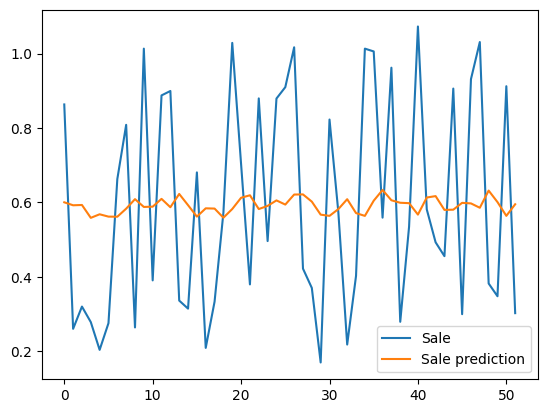

In [8]:
pl.seed_everything(33)

# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_workers = 0

# Hyperparameters
learning_rate = 0.001
batch_size = 1
num_epochs = 20 # 
time_step = 3 

# data
excel_file =r"C:\Users\Dave\Documents\GitHub\Projects\LSTM_TimeSeries\dataset\Sale_data.xlsm"
sku_list = ["SKU 3rd"]
input_size = 3 if len(sku_list) == 1 else 9



if __name__ == "__main__":
    # Load Data
    dm = SaleDataModule(data_dir=excel_file, batch_size=batch_size, num_workers=num_workers, sku_list=sku_list, time_step=time_step)
    # Initialize network
    model = NN(LSTM1(input_size=input_size))

    trainer = pl.Trainer(accelerator="cpu", devices=1, min_epochs=1, max_epochs=num_epochs, log_every_n_steps=10)
    trainer.fit(model, dm)
    trainer.validate(model, dm)
    trainer.test(model, dm)
    y_pred = trainer.predict(model, dm)
    pred_cp = prediction_comparision(y_pred, excel_file, sku_list)        
    pred_cp.line_plot()


## Model 2

Seed set to 33


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type     | Params
-------------------------------------
0 | model   | LSTM2    | 78.3 K
1 | loss_fn | mad_loss | 0     
-------------------------------------
78.3 K    Trainable params
0         Non-trainable params
78.3 K    Total params
0.313     Total estimated model params size (MB)


cpu
                                                                            

C:\Users\Dave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\Dave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 130/130 [00:01<00:00, 65.10it/s, v_num=221] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 130/130 [00:02<00:00, 64.55it/s, v_num=221]


C:\Users\Dave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 115.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     validation_loss        0.18815405666828156
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Dave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 52/52 [00:00<00:00, 225.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.26757386326789856
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Dave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 52/52 [00:00<00:00, 284.75it/s]


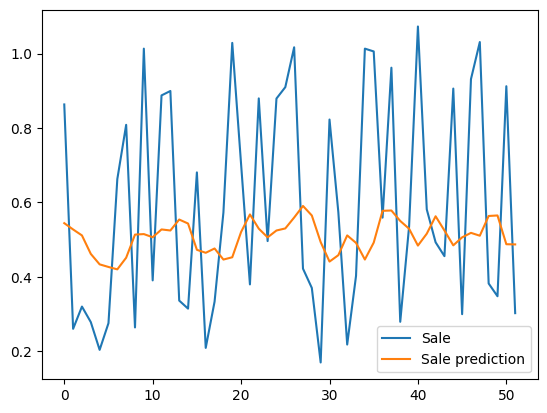

In [9]:
pl.seed_everything(33)

# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_workers = 0

# Hyperparameters
learning_rate = 0.001
batch_size = 1
num_epochs = 20 # 
time_step = 3 

# data
excel_file =r"C:\Users\Dave\Documents\GitHub\Projects\LSTM_TimeSeries\dataset\Sale_data.xlsm"
sku_list = ["SKU 3rd"]
input_size = 3 if len(sku_list) == 1 else 9



if __name__ == "__main__":
    # Load Data
    dm = SaleDataModule(data_dir=excel_file, batch_size=batch_size, num_workers=num_workers, sku_list=sku_list, time_step=time_step)
    # Initialize network
    model = NN(LSTM2(input_size=input_size))

    trainer = pl.Trainer(accelerator="cpu", devices=1, min_epochs=1, max_epochs=num_epochs, log_every_n_steps=10)
    trainer.fit(model, dm)
    trainer.validate(model, dm)
    trainer.test(model, dm)
    y_pred = trainer.predict(model, dm)
    pred_cp = prediction_comparision(y_pred, excel_file, sku_list)        
    pred_cp.line_plot()


## Model 3

Seed set to 33


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


cpu



  | Name    | Type     | Params
-------------------------------------
0 | model   | LSTM2    | 80.8 K
1 | loss_fn | mad_loss | 0     
-------------------------------------
80.8 K    Trainable params
0         Non-trainable params
80.8 K    Total params
0.323     Total estimated model params size (MB)


C:\Users\Dave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\Dave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 130/130 [00:01<00:00, 72.63it/s, v_num=222]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 130/130 [00:01<00:00, 71.98it/s, v_num=222]


C:\Users\Dave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 280.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     validation_loss        0.18767689168453217
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Dave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 52/52 [00:00<00:00, 316.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2627231478691101
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Dave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 52/52 [00:00<00:00, 129.26it/s]


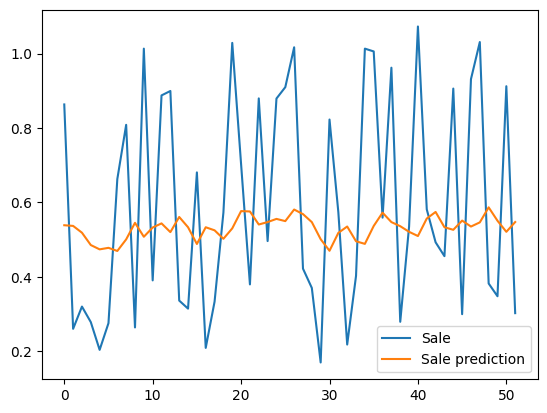

In [10]:
pl.seed_everything(33)

# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_workers = 0

# Hyperparameters
learning_rate = 0.001
batch_size = 1
num_epochs = 20 # 
time_step = 3 

# data
excel_file =r"C:\Users\Dave\Documents\GitHub\Projects\LSTM_TimeSeries\dataset\Sale_data.xlsm"
sku_list = ["SKU 3rd", "SKU 1st", "SKU 2nd"]
input_size = 3 if len(sku_list) == 1 else 9



if __name__ == "__main__":
    # Load Data
    dm = SaleDataModule(data_dir=excel_file, batch_size=batch_size, num_workers=num_workers, sku_list=sku_list, time_step=time_step)
    # Initialize network
    model = NN(LSTM2(input_size=input_size))

    trainer = pl.Trainer(accelerator="cpu", devices=1, min_epochs=1, max_epochs=num_epochs, log_every_n_steps=10)
    trainer.fit(model, dm)
    trainer.validate(model, dm)
    trainer.test(model, dm)
    y_pred = trainer.predict(model, dm)
    pred_cp = prediction_comparision(y_pred, excel_file, sku_list)        
    pred_cp.line_plot()
